# Upday Assignment / Extra


1. Library and Data Import
2. A little Analysis
3. Data Cleansing and Preparation
4. Text Vectorization w/ Doc2Vec
5. Dimensionality Reduction with Uniform Manifold Approximation and Projection (UMAP)6. Stratified Cross Validation
7. Visualisation of the Data and Categories
8. Evaluation

# 1. Library and Data Import
Let's get started with the easiest part of this task. Importing libraries, getting the necessary stopwords and importing the Dataset

In [1]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

In [398]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nlt

True

In [2]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [3]:
df = pd.read_csv('data_redacted.tsv', sep='\t')

# 2. A little Analysis

In [4]:
df.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


We are able to see that the dataset consists of the target feature "category" as well as full article text, the headline and url. At first glance, it looks promising. 

In [5]:
df.shape

(8646, 4)

Our dataset contains 8467 articles and fortunately, we do not have any missing values :D

In [6]:
df.isnull().sum()

title       0
text        0
url         0
category    0
dtype: int64

Let's check the distribution of the target feature - We see the majority class as "fashion, beauty and lifestyle" (which are my favorite topics, of course), which represents roughly 16% of the data.

In [7]:
round(df['category'].value_counts(normalize=True)*100, 2)

fashion_beauty_lifestyle    16.17
sports                      13.47
technology_science          12.03
digital_life                 8.54
money_business               8.48
news                         7.47
music                        6.57
culture                      6.33
travel                       6.29
cars_motors                  5.44
politics                     4.97
people_shows                 4.24
Name: category, dtype: float64

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

But no Juypter Notebook is complete without some bars, plots and colors, so here we go. The results match the ones you see above.

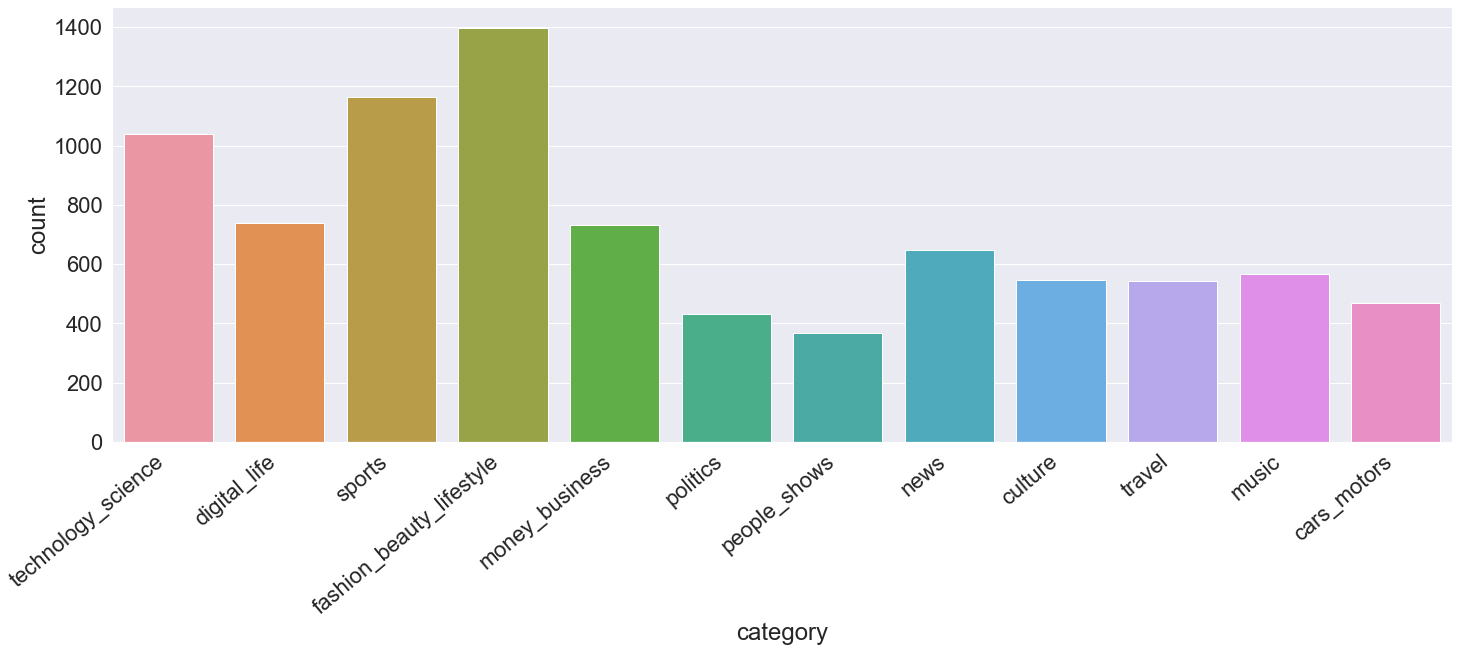

In [9]:
plt.figure(figsize=(24, 8))
sns.set(font_scale=2)
ax = sns.countplot(x="category", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

It's time for Data Cleansing and Preparation. Now the fun part starts - NOT! 
For the article body and headline we Step by step: 

1. convert all text into lowercase
2. Remove all the stopwords
3. Remove all non-alphabetic characters
4. Tokenize words for further processing

For the URL, we do it a bit differently, focusing on extracting the name of the news outlet producing the outlet. So we mainly use some REGEX magic (YESSS!) 

In [10]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
df['text'] = df['text'].str.replace('  ', ' ', regex=True)
df['token_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [11]:
df['title'] = df['title'].str.lower()
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['title'] = df['title'].str.replace('[^a-zA-Z ]', '', regex=True)
df['title'] = df['title'].str.replace('  ', ' ', regex=True)
df['token_title'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

In [12]:
df['url'] = df['url'].str.replace('http://www.', '', regex=True)
df['url'] = df['url'].str.replace('https://www.', '', regex=True)
df['url'] = df['url'].str.replace('https://', '', regex=True)
df['url'] = df['url'].str.replace('http://', '', regex=True)
df['outlet'] = df['url'].str.split('.').str[0]
df['token_outlet'] = df.apply(lambda row: nltk.word_tokenize(row['outlet']), axis=1)

Result's looking good!

In [13]:
df[['token_text', 'token_outlet', 'token_title']].head()

,token_text,token_outlet,token_title
0,"[human, chromosome, may, vanish, one, day, per...",[discovermagazine],"[dont, mourn, chromosome]"
1,"[bungie, putting, together, plans, start, sell...",[ibtimes],"[destiny, bungie, introduce, ammo, pack, micro..."
2,"[highly, rated, jehan, daruvala, race, josef, ...",[thecheckeredflag],"[daruvala, race, josef, kaufmann, racing]"
3,"[forests, important, carbon, sink, attention, ...",[sciencedaily],"[secondary, tropical, forests, absorb, carbon,..."
4,"[everyone, trying, get, eyebrows, fleek, mom, ...",[popsugar],"[brow, hack, change, way, fill, arches]"


# 4. Text Vectorization w/ Doc2Vec

After the ungrateful task of data preprocessing, we are nearing the exciting part. BUT some more data preprocessing so that the tokenized text data is in the proper format for Doc2Vec to embed it into lots of vectors.

In [14]:
df['tagtext'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_text'])]
df['tagtitle'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_title'])]
df['tagoutlet'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_outlet'])]

Once this is done - we train the one layer neural network to extract features from the text data and embed them into vectors. 

I use different parameter settings for the different inputs - since the text body contains by far the most content, we choose a vector size of 300 with 40 epochs of training. 100 vector size/10 epochs for the headlines and 20 vector size / 10 epochs for just the outlet. Depending on your computational capabilities/restrictions - feel free to go bigger or smaller, but I am sure these parameters will yield a decent enough result.

In [15]:
model_text = Doc2Vec(vector_size = 300, workers = 4, min_count=2, epochs=40)
model_text.build_vocab(df['tagtext'])
model_text.train(df['tagtext'], total_examples=model_text.corpus_count, epochs=model_text.epochs)

In [17]:
model_title = Doc2Vec(vector_size = 100, workers = 4, min_count=2, epochs=10)
model_title.build_vocab(df['tagtitle'])
model_title.train(df['tagtitle'], total_examples=model_title.corpus_count, epochs=model_title.epochs)

In [18]:
model_outlet = Doc2Vec(vector_size = 20, workers = 4, min_count=1, epochs=10)
model_outlet.build_vocab(df['tagoutlet'])
model_outlet.train(df['tagoutlet'], total_examples=model_outlet.corpus_count, epochs=model_outlet.epochs)

When then put the respective Vectors into 3 separate lists and append them to our dataframe.

In [19]:
txtvecs = []
for i in range(len(df)):
    txtvecs.append(model_text.docvecs[i])
    
titvecs = []
for i in range(len(df)):
    titvecs.append(model_title.docvecs[i])

outvecs =  []
for i in range(len(df)):
    outvecs.append(model_outlet.docvecs[i])

In [20]:
df['textvecs'] = txtvecs
df['titlevecs'] = titvecs
df['outletvecs'] = outvecs

In order, though, to make the vectors readable for our Classifier Algorithm, we must unpack each vector into a separate row/column

In [21]:
txtdf = pd.DataFrame(df.textvecs.values.tolist(), index= df.index)
txtdf.columns  = [str(col) + '_textvecs' for col in txtdf.columns]

titdf = pd.DataFrame(df.titlevecs.values.tolist(), index= df.index)
titdf.columns  = [str(col) + '_titlevecs' for col in titdf.columns]

outdf = pd.DataFrame(df.outletvecs.values.tolist(), index= df.index)
outdf.columns  = [str(col) + '_outvecs' for col in outdf.columns]

In [24]:
vectors = pd.concat([txtdf, titdf, outdf], axis=1)

Which look like this - A (not really) deep learning derived numerical representation of articles about Kim Kardashian, Donald Trump and Manchester United

In [75]:
vectors.head()

,0_textvecs,1_textvecs,2_textvecs,3_textvecs,4_textvecs,5_textvecs,6_textvecs,7_textvecs,8_textvecs,9_textvecs,...,10_outvecs,11_outvecs,12_outvecs,13_outvecs,14_outvecs,15_outvecs,16_outvecs,17_outvecs,18_outvecs,19_outvecs
0,0.379757,0.489701,0.044649,-0.323400,-1.402582,-0.095199,-0.223515,-0.412800,-0.075979,-0.468788,...,0.014410,0.003770,-0.021067,0.019913,0.008945,0.003154,0.010506,-0.008008,-0.005001,0.023728
1,0.549511,-0.101960,-0.864586,-0.895570,0.297909,0.695618,-0.719339,-0.005424,-0.595330,-0.283250,...,0.021501,0.018166,0.021676,0.020147,0.022443,-0.007399,0.022813,0.008694,-0.013869,-0.004141
2,-1.041371,0.274442,-0.239666,-0.597728,-0.100574,0.315572,-0.316570,-0.280370,-0.454697,-0.045887,...,0.002324,0.017081,0.008082,0.006417,0.013997,-0.000038,0.023607,0.017367,0.008076,0.011087
3,-0.360226,-0.329953,-0.055983,-0.810655,-1.223992,0.170581,0.216433,-0.164250,-1.387130,-1.280213,...,-0.011770,0.003336,0.023931,0.020882,-0.008083,0.013640,-0.013720,0.014974,-0.005941,0.024356
4,0.015445,-0.444218,-0.776766,0.640051,-0.700755,0.826694,-0.989046,-0.766488,0.052404,-0.446139,...,0.010196,0.007756,0.009693,-0.015976,-0.006188,-0.022450,-0.001807,-0.005209,-0.020260,0.024134


before you ask - It is fine to perform the embedding on the whole data, because the training is fully unsupervised. Lau and Baldwin (2016) explain this in detail here: https://arxiv.org/pdf/1607.05368.pdf

# 5. Dimensionality Reduction with Uniform Manifold Approximation and Projection (UMAP)

In [16]:
import umap

After importing the UMAP library, we set up the Algorithm and the parameters. Explained in simple terms, the n_neighbours parameter determines whether a more local or global data structure is pursued, basically the higher the value is, the more of a global structure is searched for within the data points.

In [69]:
embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(vectors)

C:\Anaconda3\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\Anaconda3\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


We then add the reduced embeddings to the categories - Later, we'll see why that is done

In [70]:
emb_df = pd.DataFrame(embedding)
cat_emb = pd.concat([emb_df, df['category']], axis=1)

In [76]:
cat_emb.head()

,0,1,category
0,-1.084892,0.614281,technology_science
1,-4.613204,-1.761523,digital_life
2,-5.838480,1.029818,sports
3,-1.257243,1.098480,technology_science
4,-2.551295,-1.886428,fashion_beauty_lifestyle


We now plot the reduced embeddings in a scatter plot and color the data points according to the category to which they belong. We do this to see how spatially similar or close the tha data points within a single category are to each other as well as how close/similar the categories as a whole are.

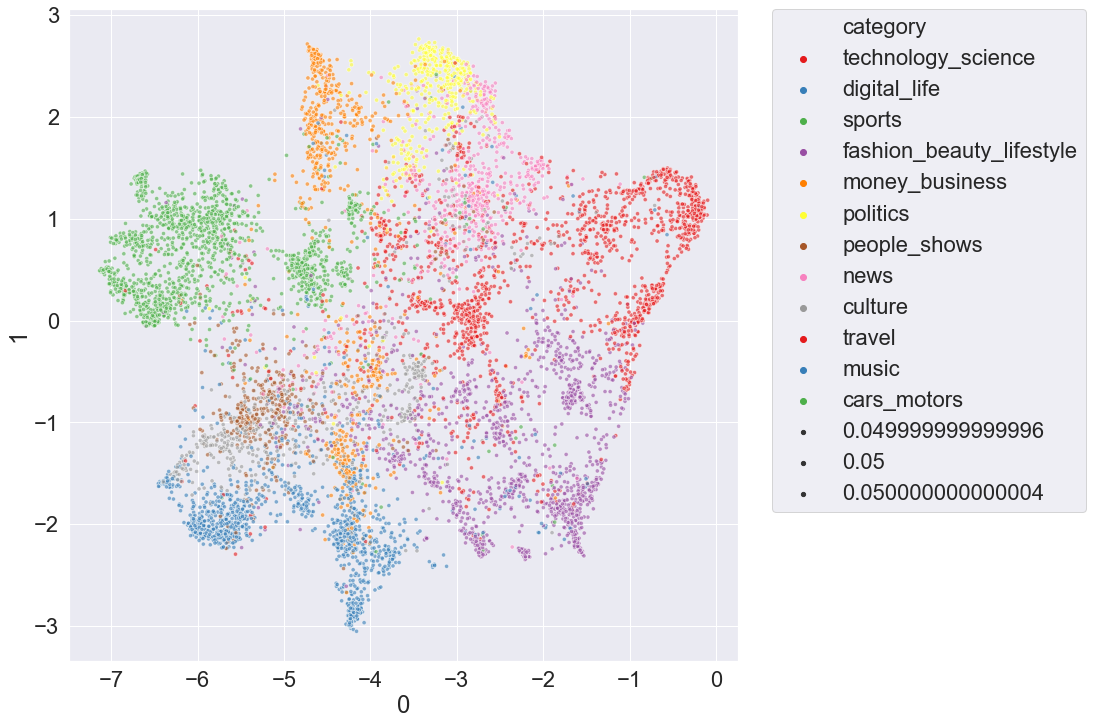

In [73]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x=0, y=1, hue="category",
                     data=cat_emb, size=0.05, alpha=.6, palette="Set1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


For some reason the legend of the categories shows some random values below that are denoted with a black dot, but I assume this to be some sort of bug in the seaborn library, since in the actual plot, no black dots show up.

Regardless, the plot looks very interesting and we can definitely extract some insights from it.

In the end of previous classification notebook, I mentioned how "news" and "politics" are often confused with each other. As we can see here, both categories seem to border each other, meaning that they appear to be semantically related and that some therefore might be falsely classified. On the other hand, "politics" and "music" are spatially speaking polar opposites and if we take a look at the confusion matrix of the classification task, we see that no "music" article has been classified as "politics" and only one "politics" article has been classified as "music".

In the general, the UMAP method of dimensionality reduction can serve several purposes. One can use it as an analytics tool to deep dive into data before algorithmic modelling to get a visual cue as to how separated the data is and what to expect from an classification. On the other hand, UMAP can also be used to reduce dimensionality as a preprocessing step as it seems to preserve the structural properties of the data very well, even when the dimension is reduced to just two components. The then reduced data can either be used for supervised or unsupervised learning, the latter being applied when categories don't yet exist and a quantitative method to define them is desired.